In [2]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, OPTICS, Birch
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from numba import njit, prange
import itertools
import math
import haversine as hs

In [3]:
df = pd.read_csv("sample_dataset.csv")

In [4]:
# the best model is the one that the weights of the clusters are the most similar and the locations are the most close to each other
def cluster_data(data, min_cluster_size, max_cluster_size, cluster_method):
    cluster_sizes = range(min_cluster_size, max_cluster_size)
    models = []
    for size in cluster_sizes:
        if cluster_method == 'kmeans':
            model = KMeans(n_clusters=size, random_state=0).fit(data)
        elif cluster_method == 'agglomerative':
            model = AgglomerativeClustering(n_clusters=size, affinity='euclidean', linkage='ward').fit(data)
        models.append(model)
    return models


def calculate_cluster_weight(model, data):
    cluster_count = len(set(model.labels_))
    cluster_weights = []
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        cluster_weight = cluster['Weight'].mean()
        cluster_weights.append(cluster_weight)
    return cluster_weights


def calculate_cluster_distance(model, data):
    cluster_count = len(set(model.labels_))
    cluster_distances = []
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        cluster_distance = cluster['Latitude'].max() - cluster['Latitude'].min() + cluster['Longitude'].max() - cluster[
            'Longitude'].min()
        cluster_distances.append(cluster_distance)
    return cluster_distances


def calculate_cluster_score(model, data):
    cluster_weights = calculate_cluster_weight(model, data)
    cluster_distances = calculate_cluster_distance(model, data)
    score = 0
    for i in range(len(cluster_weights)):
        for j in range(i + 1, len(cluster_weights)):
            score += abs(cluster_weights[i] - cluster_weights[j]) / abs(
                cluster_distances[i] - cluster_distances[j]) * 10
    return score


def calculate_best_model(models, data):
    scores = []
    for model in models:
        score = calculate_cluster_score(model, data)
        scores.append(score)
    best_model_index = scores.index(max(scores))
    return models[best_model_index]

models = cluster_data(df.iloc[:, 1:4], 2, 50, 'agglomerative')
best_model = calculate_best_model(models, df.iloc[:, 1:4])

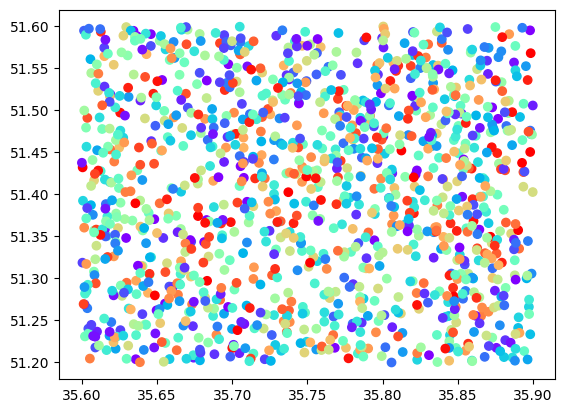

In [5]:
plt.scatter(df.iloc[:, 1], df.iloc[:, 2], c=best_model.labels_, cmap="rainbow")

<BarContainer object of 49 artists>

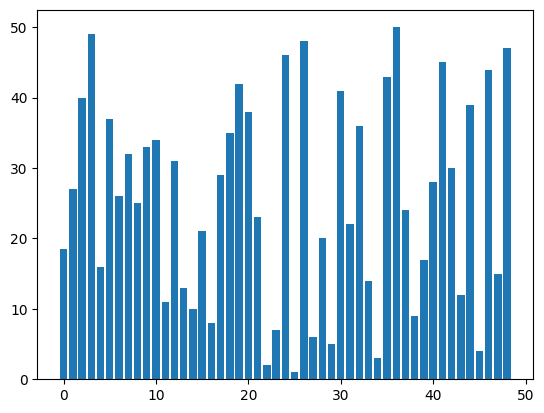

In [6]:
#bar plot of the weights of each cluster
cluster_weights = calculate_cluster_weight(best_model, df.iloc[:, 1:4])
plt.bar(range(len(cluster_weights)), cluster_weights)

In [7]:
def normal_dist(x, mean, sd):
    prob_density = (np.pi * sd) * np.exp(-0.5 * ((x - mean) / sd) ** 2)
    return prob_density


df['std_weight'] = df['Weight'].apply(lambda x: normal_dist(x, df['Weight'].mean(), df['Weight'].std()))
df

,Location ID,Latitude,Longitude,Weight,std_weight
0,1,35.857621,51.536474,8,21.580582
1,51,35.881941,51.366560,30,43.109375
2,101,35.603620,51.264557,25,45.213557
3,151,35.796481,51.437253,49,11.981049
4,201,35.780196,51.465165,14,32.849692
...,...,...,...,...,...
1245,1050,35.835749,51.357068,45,18.129390
1246,1100,35.820666,51.420291,47,14.880824
1247,1150,35.660637,51.406566,25,45.213557
1248,1200,35.664960,51.542360,46,16.464634


In [8]:
# number of locations in each cluster
def calculate_cluster_size(model, data):
    cluster_count = len(set(model.labels_))
    cluster_sizes = []
    for i in range(cluster_count):
        cluster = data[model.labels_ == i]
        cluster_size = cluster.shape[0]
        cluster_sizes.append(cluster_size)
    return cluster_sizes


calculate_cluster_size(best_model, df.iloc[:, 1:4])

[38,
 30,
 27,
 36,
 27,
 27,
 27,
 25,
 25,
 23,
 29,
 28,
 24,
 24,
 24,
 30,
 28,
 28,
 27,
 31,
 21,
 33,
 28,
 25,
 32,
 28,
 21,
 28,
 27,
 23,
 29,
 24,
 26,
 19,
 24,
 22,
 20,
 26,
 27,
 23,
 22,
 20,
 23,
 22,
 23,
 20,
 20,
 19,
 17]

<BarContainer object of 49 artists>

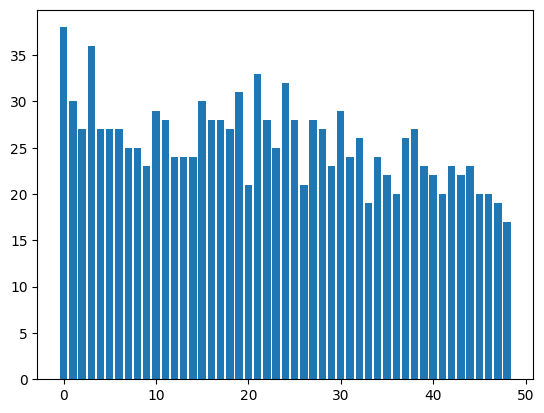

In [9]:
#bar plot of the number of locations in each cluster
cluster_sizes = calculate_cluster_size(best_model, df.iloc[:, 1:4])

plt.bar(range(len(cluster_sizes)), cluster_sizes)